In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
# Which calibration type to analyse.
calibType = 'bfk'

# This cell should be edited to match the data to be inspected.
afwDisplay.setDefaultBackend("astrowidgets")
cameraName = 'LATISS'
ptcCollection = 'u/czw/DM-28920/ptcGen.20210723Ya'
genCollection = 'u/czw/DM-28920/bfkGen.20210928-exp'
correctedCollection = 'u/czw/DM-30172/bfkV.20211102Xa'

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[genCollection, correctedCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
bfk = butler.get(calibType, instrument='LATISS', detector=0, collection=genCollection)
ptc = butler.get('ptc', instrument='LATISS', detector=0, collection=ptcCollection)

In [5]:
runStats = butler.get('verifyBfkStats', instrument=cameraName, collections=correctedCollection)
runSuccess = runStats.pop('SUCCESS')

In [6]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

ValueError: not enough values to unpack (expected 3, got 2)

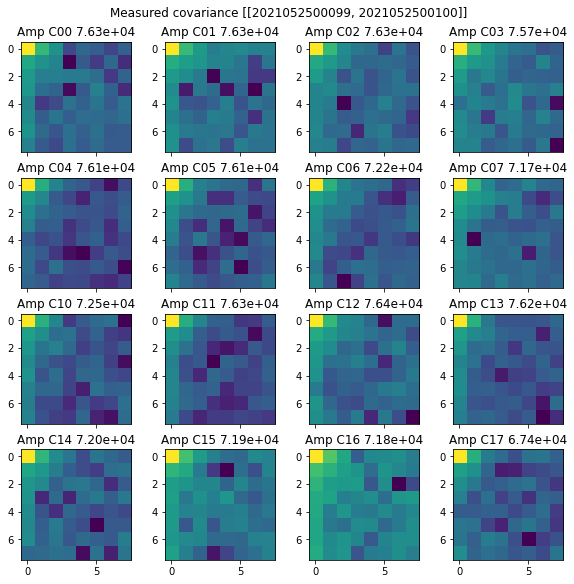

In [7]:
# Plot raw cross-correlation values
inputSelection = 11
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    covariance = ptc.covariances[ampName][inputSelection]
    axes[iterator // 4, iterator % 4].set_aspect("equal")
    axes[iterator // 4, iterator % 4].imshow(np.log10(np.abs(covariance)))
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {covariance[0][0]:.2e}")

    iterator += 1
fig.suptitle(f"Measured covariance {ptc.inputExpIdPairs[ampName][inputSelection]}")
plt.show()

/tmp/ipykernel_3193853/1375900769.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[iterator // 4, iterator % 4].imshow(np.log10(np.abs(bfk.meanXcorrs[ampName])))


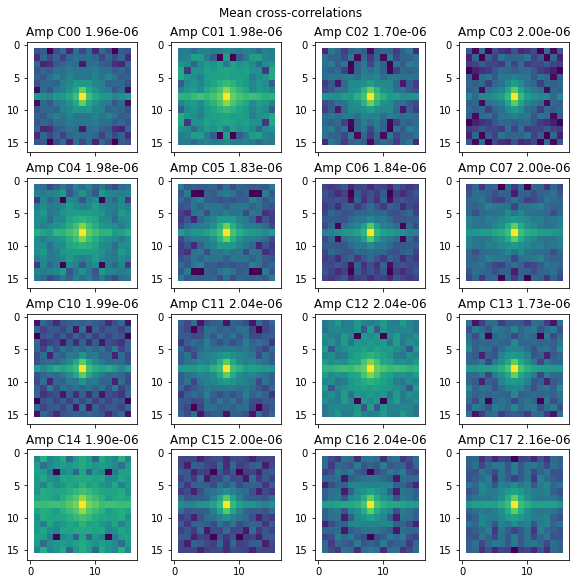

In [8]:
# Plot mean cross-correlation values
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    axes[iterator // 4, iterator % 4].set_aspect("equal")
    axes[iterator // 4, iterator % 4].imshow(np.log10(np.abs(bfk.meanXcorrs[ampName])))
    # print(ampName, iterator, iterator % 4, iterator // 4)
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {bfk.meanXcorrs[ampName][8, 8]:.2e}")

    # axes[iterator // 4 + 1, iterator % 4].plot(bfk.meanXcorrs[ampName][:, 8], label='Y-axis')
    # axes[iterator // 4 + 1, iterator % 4].plot(bfk.meanXcorrs[ampName][8, :], label='X-axis')

    # print(iterator, ampName, bfk.meanXcorrs[ampName][8, 8], np.sum(bfk.meanXcorrs[ampName], axis=None))
    iterator += 1
fig.suptitle("Mean cross-correlations")
plt.show()

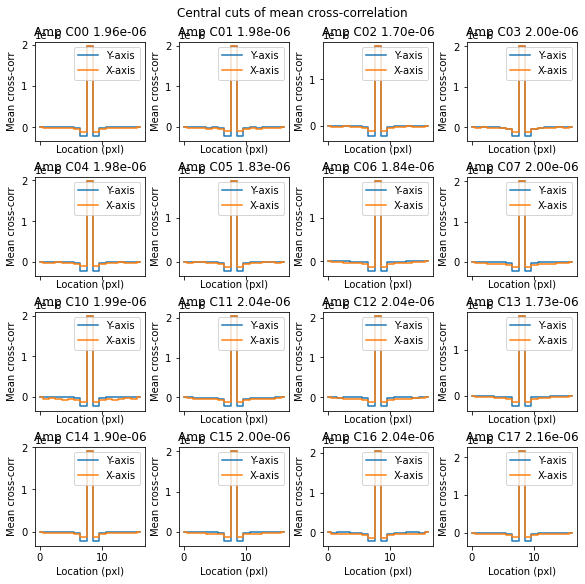

In [9]:
# Plot cuts across mean cross-correlations
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    # axes[iterator // 4, iterator % 4].set_aspect("equal")
    # axes[iterator // 4, iterator % 4].imshow(bfk.meanXcorrs[ampName])
    # print(ampName, iterator, iterator % 4, iterator // 4)
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {bfk.meanXcorrs[ampName][8, 8]:.2e}")

    axes[iterator // 4, iterator % 4].step(range(0, 17), bfk.meanXcorrs[ampName][:, 8],
                                           where='mid', label='Y-axis')
    axes[iterator // 4, iterator % 4].step(range(0, 17), bfk.meanXcorrs[ampName][8, :],
                                           where='mid', label='X-axis')
    axes[iterator // 4, iterator % 4].set_xlabel("Location (pxl)")
    axes[iterator // 4, iterator % 4].set_ylabel("Mean cross-corr")
    axes[iterator // 4, iterator % 4].legend()
    iterator += 1
fig.suptitle("Central cuts of mean cross-correlation")
plt.show()

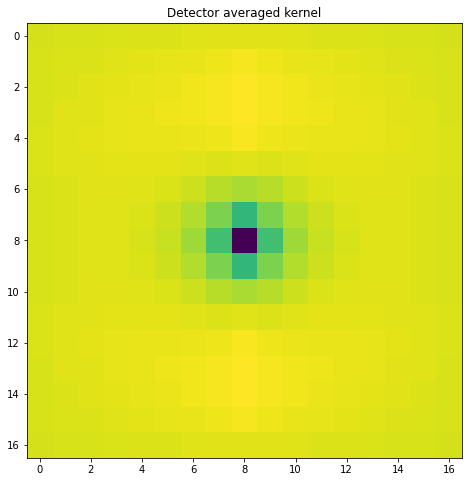

In [10]:
# Plot average kernel <-- This is what gets used in IsrTask
detector = camera[0]
detName = detector.getName()
bfk.makeDetectorKernelFromAmpwiseKernels(detName)
averageKernel = bfk.detKernels[detName]
plt.imshow(averageKernel)
plt.title("Detector averaged kernel")
plt.show()

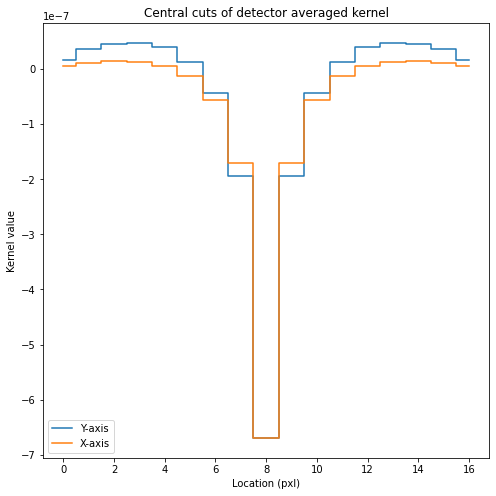

In [11]:
plt.step(range(0, 17), bfk.detKernels[detName][:, 8], 
         where='mid', label='Y-axis')
plt.step(range(0, 17), bfk.detKernels[detName][8, :], 
         where='mid', label='X-axis')
plt.legend()
plt.xlabel("Location (pxl)")
plt.ylabel("Kernel value")
plt.title("Central cuts of detector averaged kernel")
plt.show()

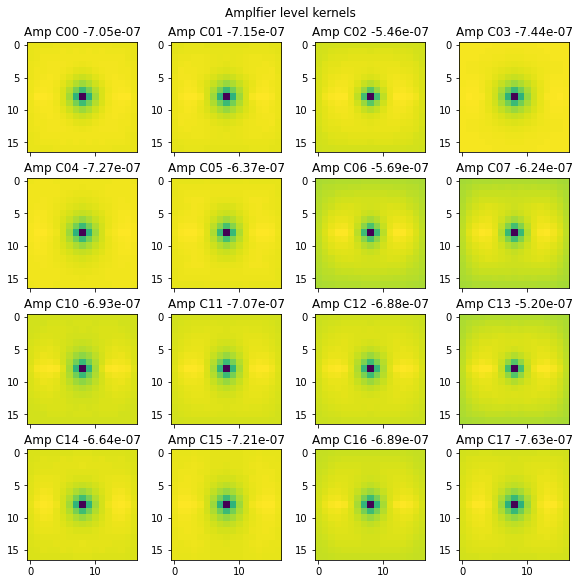

In [12]:
# Plot amp kernels
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    axes[iterator // 4, iterator % 4].set_aspect("equal")
    axes[iterator // 4, iterator % 4].imshow(bfk.ampKernels[ampName])
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {bfk.ampKernels[ampName][8, 8]:.2e}")

    iterator += 1
fig.suptitle("Amplfier level kernels")
plt.show()

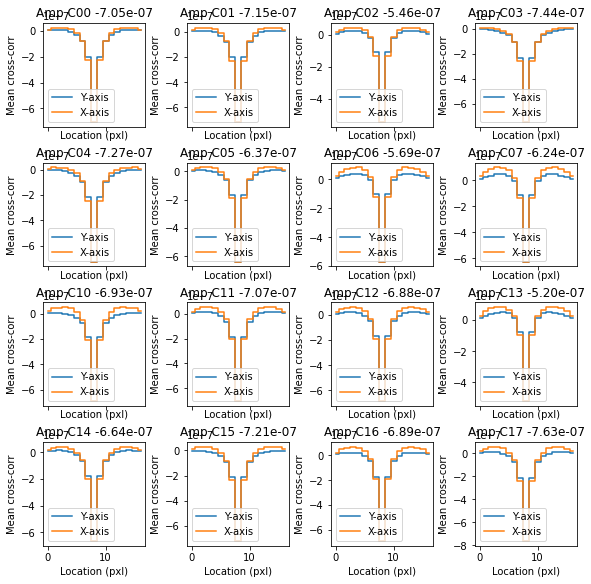

In [13]:
# Plot cuts across the amp kernels
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {bfk.ampKernels[ampName][8, 8]:.2e}")

    axes[iterator // 4, iterator % 4].step(range(0, 17), bfk.ampKernels[ampName][:, 8], 
                                           where='mid', label='Y-axis')
    axes[iterator // 4, iterator % 4].step(range(0, 17), bfk.ampKernels[ampName][8, :], 
                                           where='mid', label='X-axis')
    axes[iterator // 4, iterator % 4].set_xlabel("Location (pxl)")
    axes[iterator // 4, iterator % 4].set_ylabel("Mean cross-corr")
    axes[iterator // 4, iterator % 4].legend()

    iterator += 1
plt.show()

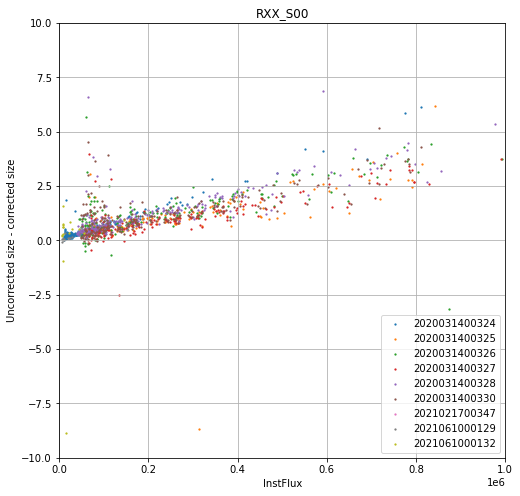

In [14]:
# Get object information
Fall = []
Tall = []
TuAll = []
for detector in camera:
    detId = detector.getId()
    for exposureId, stats in runStats.items():
        icSrc = butler.get('icSrc', collections=correctedCollection,
                           visit=exposureId, detector=detId)
        icSrcUn = butler.get('verifyUncorrBfkSrc', collections=correctedCollection,
                             visit=exposureId, detector=detId)
        if len(icSrc) != len(icSrcUn):
            continue
        T = icSrc['base_SdssShape_xx'] + icSrc['base_SdssShape_yy']
        Tp = icSrc['base_SdssShape_psf_xx'] + icSrc['base_SdssShape_psf_yy']
        F = (icSrc['base_SdssShape_instFlux'])
        Tu = icSrcUn['base_SdssShape_xx'] + icSrcUn['base_SdssShape_yy']
        Tup = icSrcUn['base_SdssShape_psf_xx'] + icSrcUn['base_SdssShape_psf_yy']
        plt.xlabel("InstFlux")
        plt.ylabel("Uncorrected size - corrected size")
        plt.ylim(-10, 10)
        plt.scatter(F, 100*(Tu - T), label=exposureId, s=1.5)
        # plt.scatter(F, (Tu - Tup)/(Tu+Tup))
        # plt.scatter(F, (T - Tp)/(T+Tp))
        Fall.extend(F)
        Tall.extend(T)
        TuAll.extend(Tu)
    plt.legend()
    plt.xlim(0, 1e6)
    plt.title(detector.getName())
    plt.grid()
    plt.show()

In [15]:
runStats

{2020031400324: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400325: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400326: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400327: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400328: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400329: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2020031400330: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2021021700347: {'SUCCESS': True},
 2021021700348: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2021021700349: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']},
 2021061000129: {'SUCCESS': True},
 2021061000132: {'FAILURES': ['RXX_S00 BRIGHT_SLOPE']}}

In [17]:
from scipy.optimize import least_squares
def f(x, a, b, c):
    return a * np.exp(b * (x + c))

def residual(p, x, y):
    return y - f(x, *p)


-0.9129901850331064


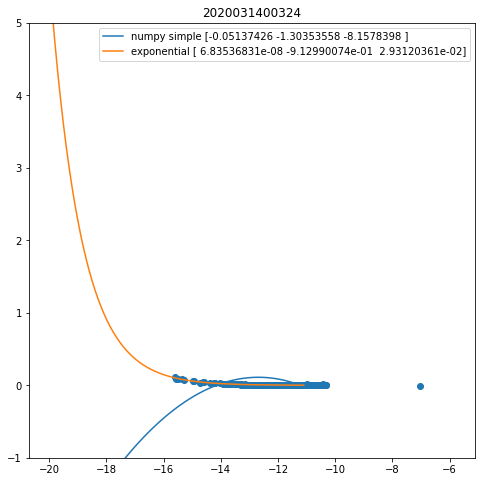

-0.8962500290569394


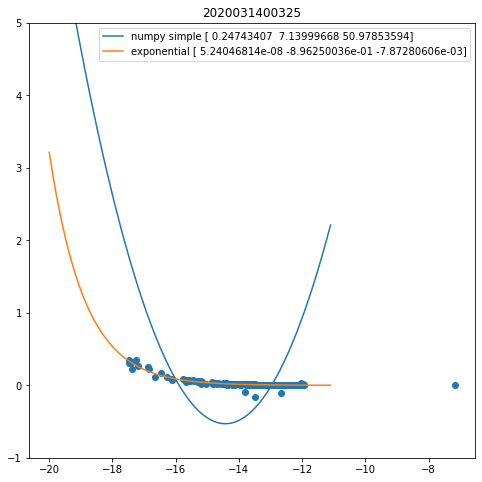

-0.9053145864639912


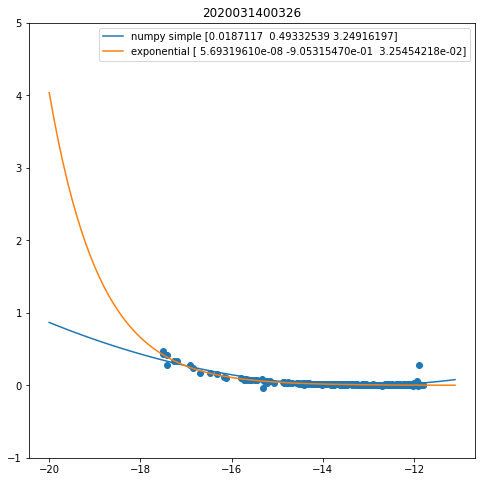

-0.9332053844234038


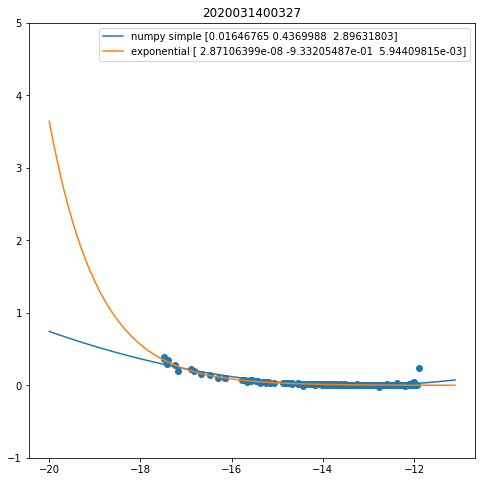

-0.8827640705893226


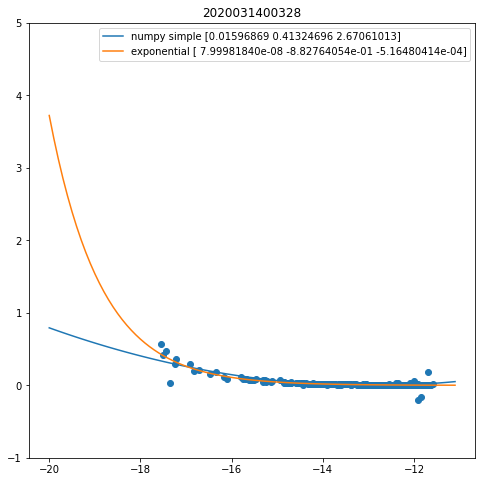

-0.9524899042456901


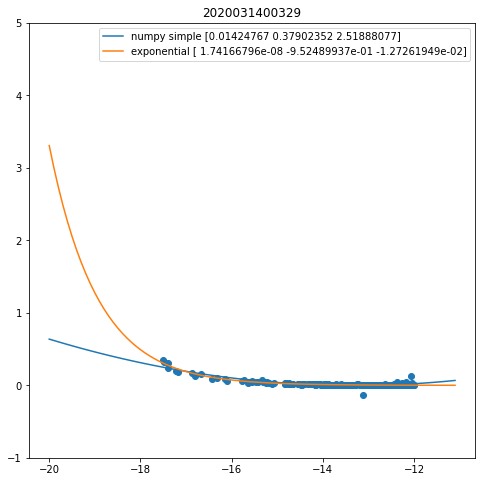

-0.9134890854825122


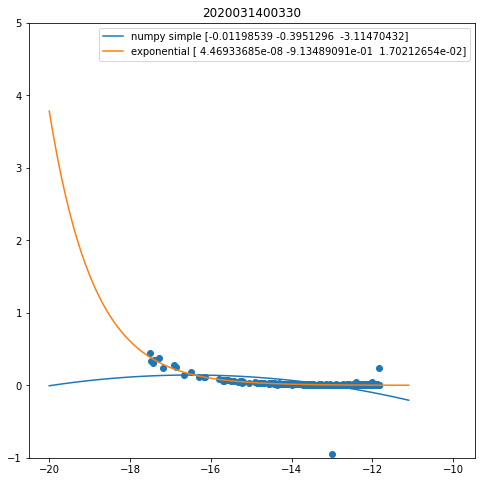

-1.2859976222949088


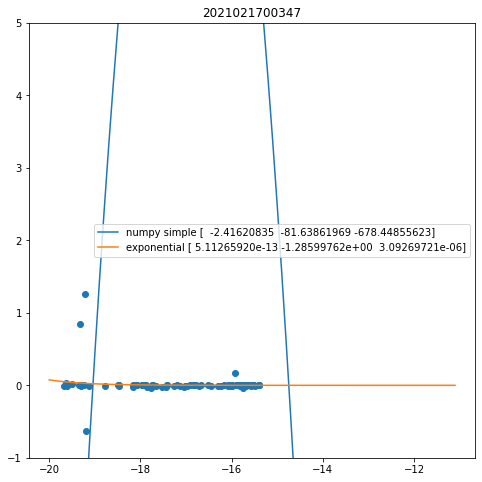

-0.7107803636889609


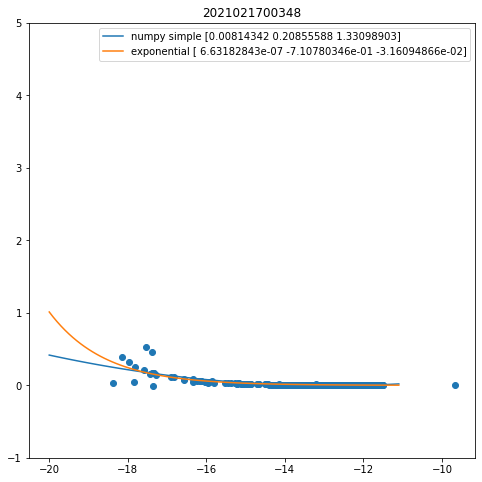

-0.5845675716734416


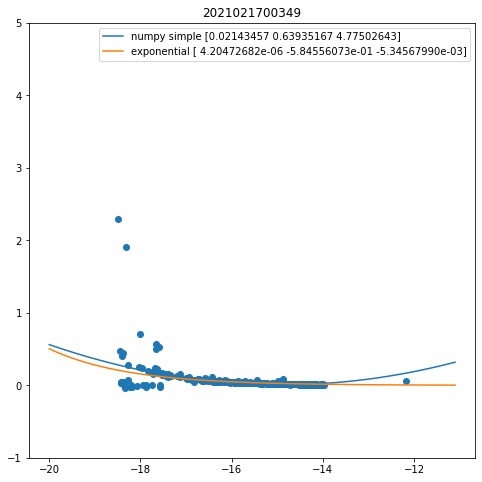

-1.2194678623993962


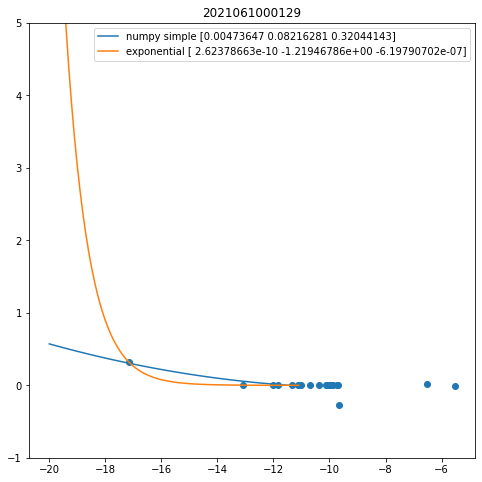

-1.6399467964891827


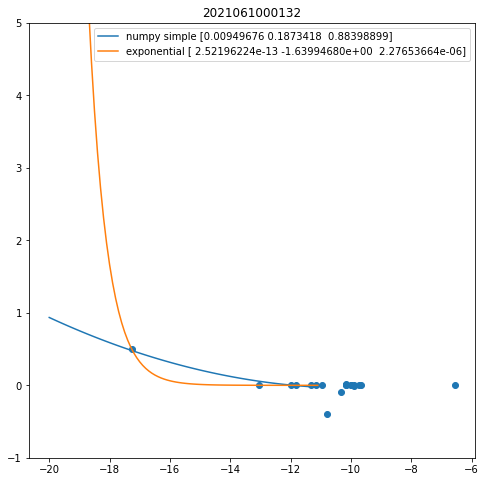

In [19]:
XX = np.arange(-20, -11, 0.1)

for exposureId in runStats.keys():
    for detector in camera:
        detStats = butler.get("verifyBfkDetStats", instrument=cameraName, detector=detector.getId(),
                             exposure=exposureId, visit=exposureId)
        print(detStats['CATALOG']['BRIGHT_SLOPE'])
        M = detStats['CATALOG']['MAGNITUDES']
        D = detStats['CATALOG']['SIZE_DIFF']
        mask = np.isfinite(M) * np.isfinite(D)
        
        p0 = [0.0, 0.0, 0.0]
        ZZ = least_squares(residual, p0, args=(np.array(M)[mask], np.array(D)[mask]), loss='cauchy')
        pf = np.polyfit(np.array(M)[mask], np.array(D)[mask], 2)
        
        plt.scatter(detStats['CATALOG']['MAGNITUDES'], detStats['CATALOG']['SIZE_DIFF'])
        plt.plot(XX, np.polyval(pf, XX), label=f"numpy simple {pf}")
        # plt.plot(XX, np.polyval(ZZ.x, XX), label="robust")
        plt.plot(XX, f(XX, *ZZ.x), label=f"exponential {ZZ.x}")
        plt.ylim(-1, 5)
        plt.legend()

        plt.title(exposureId)
        plt.show()